In [39]:
# =====================================================================
# Step 1: Import required libraries and define project directories
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Define important project paths
ROOT = Path(".").resolve()
DATA_DIR = ROOT / "BODMAS"
ART_DIR = ROOT / "artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

# Configure visualization and pandas options
pd.set_option("display.max_columns", 10)
plt.style.use("seaborn-v0_8-whitegrid")

print(f"Data directory: {DATA_DIR}")

Data directory: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/BODMAS


In [40]:
# =====================================================================
# Step 2: Load the BODMAS dataset
# ---------------------------------------------------------------------
# The dataset contains pre-extracted feature matrices and labels saved
# in NumPy .npz format. Some versions contain pickled Python objects,
# so we enable allow_pickle=True for compatibility.
#
# This step also loads bodmas_metadata.csv to retrieve the SHA hashes
# (here the column is named 'sha') that uniquely identify each sample
# for alignment across later pipelines.
# =====================================================================

import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path("BODMAS")

# Load the .npz feature file
npz_path = DATA_DIR / "bodmas.npz"
npz = np.load(npz_path, allow_pickle=True)

# Extract feature matrix and labels
X = npz["X"]
y = npz["y"].astype(int)

# Load metadata (contains sample hash and other details)
meta_path = DATA_DIR / "bodmas_metadata.csv"
meta = pd.read_csv(meta_path)

# Standardize column name (your file uses 'sha')
if "sha" in meta.columns:
    meta.rename(columns={"sha": "sha256"}, inplace=True)
else:
    raise KeyError(f"'sha' column not found in metadata. Columns: {meta.columns.tolist()}")

# Attach SHA256 identifiers (aligned to feature count)
sha256_ids = meta["sha256"].values[: len(X)]

print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape:   {y.shape}")
print(f"Metadata shape:       {meta.shape}")
print(f"SHA identifiers attached: {len(sha256_ids)} samples")

# Preview metadata to ensure successful load
meta.head()

Feature matrix shape: (134435, 2381)
Label vector shape:   (134435,)
Metadata shape:       (134435, 3)
SHA identifiers attached: 134435 samples


,sha256,timestamp,family
0,e6d7b4bab32def853ab564410df53fa33172dda1bfd48c...,2007-01-01 08:46:39+00:00,NaN
1,5af37a058a5bcf2284c183ee98d92b7c66d8f5ce623e92...,2007-01-26 17:16:30+00:00,NaN
2,5bfbbea150af5cef2d3a93b80ef7c7faea9f564b56045d...,2007-03-21 02:08:53+00:00,NaN
3,216f592f1e1717d5681b7f5f2b14a28a2f0c603b5b7318...,2007-04-25 12:55:06+00:00,NaN
4,a1ca76813d2e9e7e23b830c87fbe29bcb51fcbe096e445...,2007-11-14 15:03:55+00:00,NaN


In [41]:
# =====================================================================
# Step 3: Data Cleaning and Validation
# ---------------------------------------------------------------------
# This stage ensures data integrity and consistency across the feature,
# label, and metadata files. The cleaning process:
#   1. Validates SHA identifiers to confirm sample uniqueness.
#   2. Converts and verifies timestamp fields.
#   3. Removes incomplete or corrupted entries.
#   4. Confirms structural alignment between X, y, and metadata.
# =====================================================================

# Record the initial number of samples for reference.
initial_count = len(meta)

# Convert timestamps to standardized UTC datetime objects if present.
# Invalid or unparseable values will be coerced to NaT.
if "timestamp" in meta.columns:
    meta["timestamp"] = pd.to_datetime(meta["timestamp"], utc=True, errors="coerce")
else:
    print("Note: 'timestamp' column not found in metadata; timestamp validation skipped.")
    meta["timestamp"] = pd.NaT

# Count invalid timestamps before any filtering.
invalid_timestamps = meta["timestamp"].isna().sum()
if invalid_timestamps > 0:
    print(f"{invalid_timestamps} invalid or missing timestamps identified; these records will be removed.")

# Validate SHA identifiers. A valid SHA256 value must contain 64 hexadecimal characters.
if "sha256" not in meta.columns:
    raise KeyError("Expected 'sha256' column not found in metadata after preprocessing step.")
valid_sha_mask = meta["sha256"].astype(str).str.len() == 64

# Apply SHA-based filtering to ensure sample integrity.
X = X[valid_sha_mask]
y = y[valid_sha_mask]
meta = meta.loc[valid_sha_mask].reset_index(drop=True)

# Remove records with invalid or missing timestamps.
valid_timestamp_mask = meta["timestamp"].notna()
X = X[valid_timestamp_mask]
y = y[valid_timestamp_mask]
meta = meta.loc[valid_timestamp_mask].reset_index(drop=True)

# Final consistency check: confirm structural alignment.
assert len(X) == len(y) == len(meta), (
    f"Data misalignment detected after cleaning. "
    f"Shapes -> X: {len(X)}, y: {len(y)}, meta: {len(meta)}"
)

# Report final counts for documentation and reproducibility.
final_count = len(meta)

print("Dataset after validation and cleaning:")
print(f"  Initial samples:            {initial_count}")
print(f"  Invalid timestamps removed: {invalid_timestamps}")
print(f"  Remaining valid samples:    {final_count}")
print(f"  Benign samples:             {(y == 0).sum()}")
print(f"  Malware samples:            {(y == 1).sum()}")
print(f"  All remaining timestamps valid: {meta['timestamp'].notna().all()}")

3712 invalid or missing timestamps identified; these records will be removed.
Dataset after validation and cleaning:
  Initial samples:            134435
  Invalid timestamps removed: 3712
  Remaining valid samples:    130716
  Benign samples:             73423
  Malware samples:            57293
  All remaining timestamps valid: True


/var/folders/0_/2jfg6k954vx44d4w9209s0tw0000gn/T/ipykernel_15068/1364382092.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette="Set2")


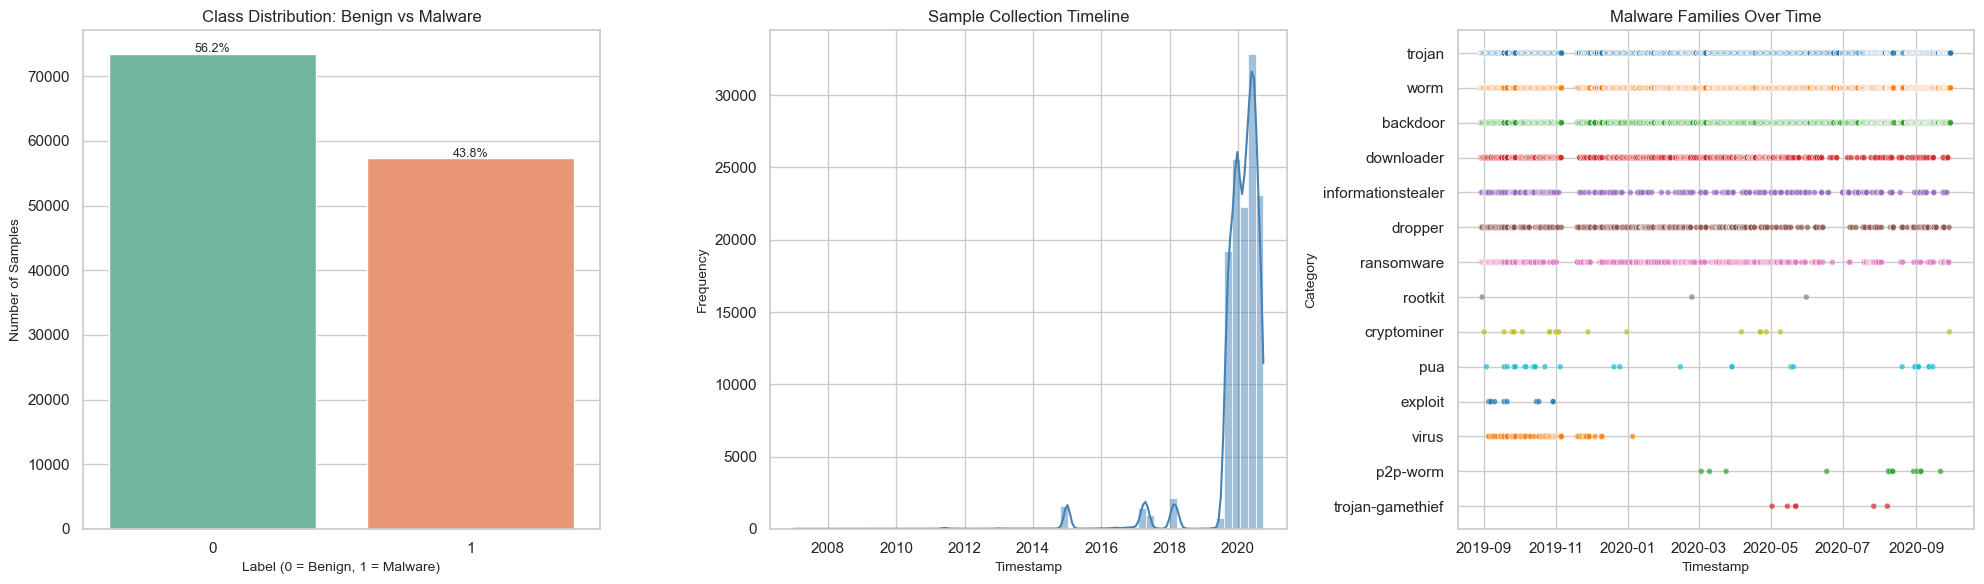

Timestamp Summary:
  Earliest sample : 2007-01-01 08:46:39+00:00
  Latest sample   : 2020-09-30 03:05:27+00:00
  Date range span : 5020 days
  Unique malware families: 14


In [45]:
# =====================================================================
# Step 4: Exploratory Data Analysis (EDA)
# ---------------------------------------------------------------------
# Purpose:
#   - Visualize class balance (benign vs malware)
#   - Examine temporal sample distribution
#   - Analyze malware family trends over time
# =====================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------
# Load and align malware category mapping with metadata
# ---------------------------------------------------------------------
cat_path = DATA_DIR / "bodmas_malware_category.csv"
malware_categories = pd.read_csv(cat_path)

# Standardize the column names in both DataFrames before merging
if "sha" in malware_categories.columns:
    malware_categories.rename(columns={"sha": "sha256"}, inplace=True)
elif "sha256_hash" in malware_categories.columns:
    malware_categories.rename(columns={"sha256_hash": "sha256"}, inplace=True)

if "sha256" not in malware_categories.columns:
    raise KeyError(
        f"No valid SHA column found in malware category file. "
        f"Available columns: {malware_categories.columns.tolist()}"
    )

# Merge by sha256 to keep metadata alignment
meta = meta.merge(malware_categories, on="sha256", how="left")

# ---------------------------------------------------------------------
# Configure plot aesthetics
# ---------------------------------------------------------------------
sns.set_theme(style="whitegrid", palette="muted")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ============================================================
# Plot 1: Class distribution
# ============================================================
class_counts = pd.Series(y).value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette="Set2")
axes[0].set_title("Class Distribution: Benign vs Malware", fontsize=12)
axes[0].set_xlabel("Label (0 = Benign, 1 = Malware)", fontsize=10)
axes[0].set_ylabel("Number of Samples", fontsize=10)

for i, count in enumerate(class_counts.values):
    pct = count / len(y) * 100
    axes[0].text(i, count + (len(y) * 0.002), f"{pct:.1f}%", ha="center", fontsize=9)

# ============================================================
# Plot 2: Timestamp distribution
# ============================================================
meta_sorted = meta.sort_values("timestamp")
sns.histplot(
    data=meta_sorted,
    x="timestamp",
    bins=60,
    kde=True,
    color="steelblue",
    ax=axes[1]
)
axes[1].set_title("Sample Collection Timeline", fontsize=12)
axes[1].set_xlabel("Timestamp", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)

# ============================================================
# Plot 3: Malware family timeline
# ============================================================
meta_malware = meta[meta["category"].notna()].sort_values("timestamp")
unique_cats = meta_malware["category"].nunique()
palette = sns.color_palette("tab10", n_colors=unique_cats)

sns.scatterplot(
    data=meta_malware,
    x="timestamp",
    y="category",
    hue="category",
    palette=palette,
    s=18,
    alpha=0.7,
    ax=axes[2],
    legend=False
)
axes[2].set_title("Malware Families Over Time", fontsize=12)
axes[2].set_xlabel("Timestamp", fontsize=10)
axes[2].set_ylabel("Category", fontsize=10)

# ---------------------------------------------------------------------
# Render plots and print temporal summary
# ---------------------------------------------------------------------
plt.tight_layout()
plt.show()

print("Timestamp Summary:")
print(f"  Earliest sample : {meta['timestamp'].min()}")
print(f"  Latest sample   : {meta['timestamp'].max()}")
print(f"  Date range span : {(meta['timestamp'].max() - meta['timestamp'].min()).days} days")
print(f"  Unique malware families: {unique_cats}")

In [48]:
# =====================================================================
# Step 5: Time-Aware Dataset Splitting
# ---------------------------------------------------------------------
# Objectives:
#   1. Split samples chronologically into Train, Validation, and Test sets.
#   2. Maintain the natural time progression of malware evolution.
#   3. Save index arrays for reproducibility.
#
# Split proportions:
#   - Training:    70%  (oldest data)
#   - Validation:  15%  (middle period)
#   - Test:        15%  (most recent data)
# =====================================================================

def time_based_split(metadata: pd.DataFrame,
                     train_fraction: float = 0.70,
                     val_fraction: float = 0.15):
    """
    Split dataset indices into chronological Train/Val/Test subsets.

    Parameters
    ----------
    metadata : pd.DataFrame
        DataFrame containing a 'timestamp' column.
    train_fraction : float
        Fraction of earliest samples for training.
    val_fraction : float
        Fraction of middle samples for validation.

    Returns
    -------
    tuple of np.ndarray
        (train_indices, val_indices, test_indices)
    """
    # Convert timestamps to integer nanoseconds for quantile calculation
    timestamps = metadata["timestamp"].astype("int64")

    # Compute boundaries for train and validation quantiles
    q_train, q_val = np.nanquantile(timestamps, [train_fraction, train_fraction + val_fraction])

    # Create index arrays for each split
    idx_train = metadata.index[timestamps <= q_train].to_numpy()
    idx_val   = metadata.index[(timestamps > q_train) & (timestamps <= q_val)].to_numpy()
    idx_test  = metadata.index[timestamps > q_val].to_numpy()

    return idx_train, idx_val, idx_test


# ---------------------------------------------------------------------
# Apply the splitting function
# ---------------------------------------------------------------------
idx_train, idx_val, idx_test = time_based_split(meta)

# ---------------------------------------------------------------------
# Display split statistics and boundaries
# ---------------------------------------------------------------------
n_total = len(meta)
print("Dataset split summary (chronological):")
print(f"  Training samples   : {len(idx_train)}  ({len(idx_train)/n_total:.1%})")
print(f"  Validation samples : {len(idx_val)}  ({len(idx_val)/n_total:.1%})")
print(f"  Test samples       : {len(idx_test)}  ({len(idx_test)/n_total:.1%})")

print("\nTime range per subset:")
print(f"  Train start : {meta.loc[idx_train, 'timestamp'].min()}")
print(f"  Train end   : {meta.loc[idx_train, 'timestamp'].max()}")
print(f"  Val start   : {meta.loc[idx_val, 'timestamp'].min()}")
print(f"  Val end     : {meta.loc[idx_val, 'timestamp'].max()}")
print(f"  Test start  : {meta.loc[idx_test, 'timestamp'].min()}")
print(f"  Test end    : {meta.loc[idx_test, 'timestamp'].max()}")

# ---------------------------------------------------------------------
# Integrity check to ensure no overlap between subsets
# ---------------------------------------------------------------------
assert set(idx_train).isdisjoint(idx_val)
assert set(idx_val).isdisjoint(idx_test)
assert set(idx_train).isdisjoint(idx_test)
print("\nVerification passed: No overlap between subsets.")

Dataset split summary (chronological):
  Training samples   : 91501  (70.0%)
  Validation samples : 19608  (15.0%)
  Test samples       : 19607  (15.0%)

Time range per subset:
  Train start : 2007-01-01 08:46:39+00:00
  Train end   : 2020-05-30 23:00:50+00:00
  Val start   : 2020-05-30 23:01:16+00:00
  Val end     : 2020-07-17 07:19:30+00:00
  Test start  : 2020-07-17 07:19:31+00:00
  Test end    : 2020-09-30 03:05:27+00:00

Verification passed: No overlap between subsets.


In [49]:
# =====================================================================
# Step 6: Scale numerical features and save preprocessing artifacts
# ---------------------------------------------------------------------
# Objectives:
#   1. Fit StandardScaler on training data only (no leakage).
#   2. Persist scaler and split indices for reproducibility.
# =====================================================================

from sklearn.preprocessing import StandardScaler
import joblib, json, numpy as np

# Fit scaler on training data only
scaler = StandardScaler()
scaler.fit(X[idx_train])

# Create artifacts directory if it does not exist
ART_DIR.mkdir(parents=True, exist_ok=True)

# Save the scaler for reuse in feature engineering and modeling
joblib.dump(scaler, ART_DIR / "scaler.joblib")

# Save the full dataset and split indices
np.savez_compressed(
    ART_DIR / "Xy_splits.npz",
    X=X,
    y=y,
    idx_train=idx_train,
    idx_val=idx_val,
    idx_test=idx_test
)

# Save split size summary
split_summary = {
    "train": int(len(idx_train)),
    "val": int(len(idx_val)),
    "test": int(len(idx_test))
}
json.dump(split_summary, open(ART_DIR / "splits.json", "w"), indent=2)

print("Preprocessing artifacts saved successfully in:", ART_DIR)
for file in ART_DIR.iterdir():
    print(" -", file.name)

Preprocessing artifacts saved successfully in: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/artifacts
 - best_baseline_LightGBM.joblib
 - baseline_summary.json
 - X_train_enh.parquet
 - splits.json
 - scaler.joblib
 - eda.json
 - Xy_splits.npz
 - X_test_enh.parquet
 - baseline_results.csv
 - X_val_enh.parquet


In [51]:
# =====================================================================
# Step 7: Save EDA summary for reporting
# ---------------------------------------------------------------------
# Captures key dataset-level statistics for documentation and
# downstream reproducibility. This includes class balance, feature
# dimensionality, and malware family diversity.
# =====================================================================

import json

eda_summary = {
    "total_samples": int(len(y)),
    "n_features": int(X.shape[1]),
    "class_counts": {
        "benign": int((y == 0).sum()),
        "malware": int((y == 1).sum())
    },
    "date_range": {
        "min": str(meta["timestamp"].min()),
        "max": str(meta["timestamp"].max())
    },
    "unique_malware_families": int(meta["category"].nunique()) if "category" in meta.columns else None
}

# Write JSON summary to artifact directory
json.dump(eda_summary, open(ART_DIR / "eda.json", "w"), indent=2)

print("EDA summary written to:", ART_DIR / "eda.json")
print("Summary details:")
for k, v in eda_summary.items():
    print(f"  {k}: {v}")

EDA summary written to: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/artifacts/eda.json
Summary details:
  total_samples: 130716
  n_features: 2381
  class_counts: {'benign': 73423, 'malware': 57293}
  date_range: {'min': '2007-01-01 08:46:39+00:00', 'max': '2020-09-30 03:05:27+00:00'}
  unique_malware_families: 14


In [52]:
# =====================================================================
# Step 8: Verify that artifacts load correctly
# =====================================================================

import json

print("Files in artifacts/:")
for p in ART_DIR.iterdir():
    print(" -", p.name)

# Load back to confirm integrity
s = np.load(ART_DIR / "Xy_splits.npz")
scaler_check = joblib.load(ART_DIR / "scaler.joblib")
eda_check = json.load(open(ART_DIR / "eda.json"))

print("\nVerification:")
print("Scaler fitted on:", scaler_check.mean_.shape[0], "features")
print("Train size:", len(s["idx_train"]))
print("Val size:", len(s["idx_val"]))
print("Test size:", len(s["idx_test"]))
print("EDA summary:", eda_check)

Files in artifacts/:
 - best_baseline_LightGBM.joblib
 - baseline_summary.json
 - X_train_enh.parquet
 - splits.json
 - scaler.joblib
 - eda.json
 - Xy_splits.npz
 - X_test_enh.parquet
 - baseline_results.csv
 - X_val_enh.parquet

Verification:
Scaler fitted on: 2381 features
Train size: 91501
Val size: 19608
Test size: 19607
EDA summary: {'total_samples': 130716, 'n_features': 2381, 'class_counts': {'benign': 73423, 'malware': 57293}, 'date_range': {'min': '2007-01-01 08:46:39+00:00', 'max': '2020-09-30 03:05:27+00:00'}, 'unique_malware_families': 14}
